In [1]:
import numpy as np 
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Датасет - `bus_table.csv`
- `data` - дата
- `route` - название маршрута автобуса
- `direction` - направление маршрута
- `scheduled` - время прибыттия по расписанию
- `actual` - фактическое время прибытия

## Задание 1
Прочитайте файл, сохранив результаты в `df`. Посмотрите статистики и инфо.

In [2]:
df = pd.read_csv("bus_table.csv")

In [3]:
display(df.head(3))
display(df.info())
display(df.describe())

,data,route,direction,scheduled,actual
0,2016-03-26,A,south,01:11:57,01:13:19
1,2016-03-26,A,south,23:19:57,23:16:13
2,2016-03-26,A,south,21:19:57,21:18:46


<class 'pandas.core.frame.DataFrame'>
Index: 39157 entries, 0 to 39156
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       39157 non-null  object
 1   route      39157 non-null  object
 2   direction  39157 non-null  object
 3   scheduled  38917 non-null  object
 4   actual     39157 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


None

,data,route,direction,scheduled,actual
count,39157,39157,39157,38917,39157
unique,63,3,2,1356,27633
top,2016-04-14,A,north,23:00:25,08:08:24
freq,693,13358,19686,64,8


## Задание 2
Вырежте пропушеные данные (сохраните их в DataFrame `df_null`, они вам еще понадобятся) и удалите их из `df`. Выведите размерность `df_null`.

In [4]:
df_null = df[df['scheduled'].isna()].reset_index(drop=True)
df_new = df[~df['scheduled'].isna()].reset_index(drop=True)
df_null.shape

(240, 5)

In [5]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38917 entries, 0 to 38916
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       38917 non-null  object
 1   route      38917 non-null  object
 2   direction  38917 non-null  object
 3   scheduled  38917 non-null  object
 4   actual     38917 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


## Задание 3
1. Добавьте столбец `table` дату/время прибытия автобусов по расписанию на остановку. 
2. Добавьте столбец `arrival` дату/временя актуального прибытия автобуса на остановку.


In [6]:
df_new['table'] = df_new[['data', 'scheduled']].agg(' '.join, axis=1)
df_new['arrival'] = df_new[['data', 'actual']].agg(' '.join, axis=1)
df_new.head(3)

,data,route,direction,scheduled,actual,table,arrival
0,2016-03-26,A,south,01:11:57,01:13:19,2016-03-26 01:11:57,2016-03-26 01:13:19
1,2016-03-26,A,south,23:19:57,23:16:13,2016-03-26 23:19:57,2016-03-26 23:16:13
2,2016-03-26,A,south,21:19:57,21:18:46,2016-03-26 21:19:57,2016-03-26 21:18:46


In [7]:
# преобразуем в тип дата
df_new.table = pd.to_datetime(df_new.table)
df_new.arrival = pd.to_datetime(df_new.arrival)

## Задание 4
1. Найдите три самых часто встречаюшихся в расписании автобусов временных интервалов (естественно для каждой возможной пары номер маршрута-направление).

2. Добавьте в таблицу столбик `inteval` - интервал по расписаню между автобусами (естественно одного маршрута и направления) в МИНУТАХ.

3. Добавьте в таблицу столбик `arr_inteval` - интервал по фактическому между автобусами (естественно одного маршрута и направления) в МИНУТАХ.

In [8]:
# Отсортируем для дальнейший действий данные по времени прибывания для каждого маршрута и направления
df_new = df_new.sort_values(['route', 'direction', 'table']).reset_index(drop=True)

# Добавим интервал по расписанию
df_new['interval'] = df_new.groupby(['route', 'direction'])['table'].diff()
df_new['interval'] = df_new['interval'].dt.total_seconds().div(60)

# Добавим интервал по фактическому
df_new['arr_interval'] = df_new.groupby(['route', 'direction'])['arrival'].diff()
df_new['arr_interval'] = df_new['arr_interval'].dt.total_seconds().div(60)
## Исправим ошибки ##
df_new.loc[df_new['arr_interval'] > 1080, 'arr_interval'] -= 1440
df_new.loc[df_new['arr_interval'] < -1080, 'arr_interval'] += 1440

# with pd.option_context('display.max_rows', None):
#          display(df_new[:100])
df_new.head(3)

,data,route,direction,scheduled,actual,table,arrival,interval,arr_interval
0,2016-03-26,A,north,00:00:25,00:05:01,2016-03-26 00:00:25,2016-03-26 00:05:01,NaN,NaN
1,2016-03-26,A,north,00:30:25,00:30:19,2016-03-26 00:30:25,2016-03-26 00:30:19,30.0,25.300000
2,2016-03-26,A,north,01:05:25,01:10:15,2016-03-26 01:05:25,2016-03-26 01:10:15,35.0,39.933333


In [9]:
# Три самых часто встречаюшихся в расписании автобусов временных интервалов
top = df_new.groupby(['route', 'direction'])['interval'].value_counts()
top = top.groupby(['route', 'direction']).head(3)
display(top)

route  direction  interval
A      north      12.0        1434
                  15.0        1377
                  7.0          756
       south      15.0        1453
                  12.0        1312
                  8.0          710
B      north      15.0        1507
                  12.0        1413
                  8.0         1141
       south      15.0        1391
                  12.0        1300
                  8.0         1159
C      north      10.0        1869
                  15.0         590
                  6.0          552
       south      10.0        1342
                  12.0        1087
                  15.0        1049
Name: count, dtype: int64

## Задание 5
Найдите время в минутах для опоздания авдобуса (+ задержка, - раньше расписания)

In [10]:
# Время в минутах для опоздания автобуса
df_new['delay'] = df_new['arrival'] - df_new['table']
df_new['delay'] = df_new['delay'].dt.total_seconds().div(60)
## Исправляем ошибки ##
df_new.loc[df_new['delay'] > 1080, 'delay'] -= 1440
df_new.loc[df_new['delay'] < -1080, 'delay'] += 1440
# with pd.option_context('display.max_rows', None):
#          display(df_new[:100])
display(df_new.head(3))

,data,route,direction,scheduled,actual,table,arrival,interval,arr_interval,delay
0,2016-03-26,A,north,00:00:25,00:05:01,2016-03-26 00:00:25,2016-03-26 00:05:01,NaN,NaN,4.600000
1,2016-03-26,A,north,00:30:25,00:30:19,2016-03-26 00:30:25,2016-03-26 00:30:19,30.0,25.300000,-0.100000
2,2016-03-26,A,north,01:05:25,01:10:15,2016-03-26 01:05:25,2016-03-26 01:10:15,35.0,39.933333,4.833333


## Задание 6
1. Постройте максимально качественные гистограммы (или их аналоги) для разницы интервалов между автобусами для различных маршрутов и направлений.

2. Постройте максимально качественные гистограммы (или их аналоги) времени опоздания автобуса в зависимости от маршрута и направления.

   Увидели абсурд - возращаемся к началу и латаем код ;)

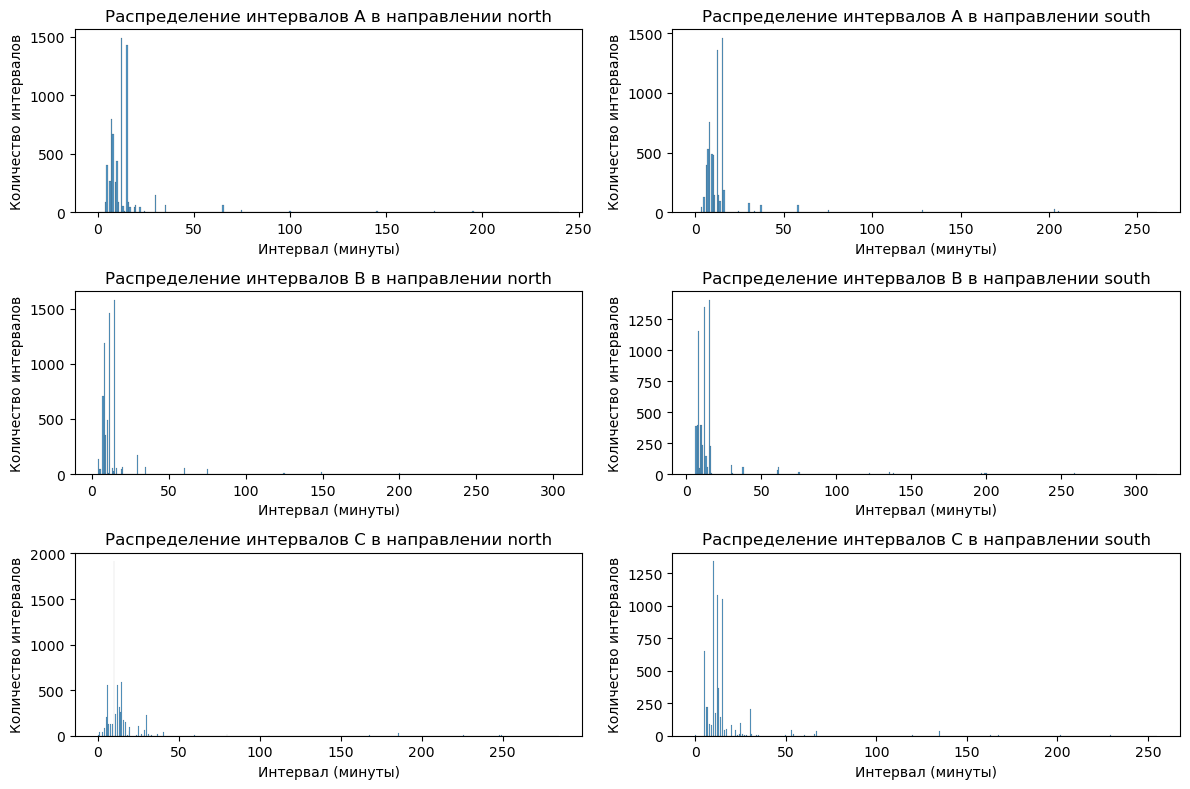

In [11]:
# Создаем гистограммы для разницы интервалов между автобусами
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for i, route in enumerate(df_new['route'].unique()):
    df_route = df_new[df_new['route'] == route]

    for j, direction in enumerate(df_new['direction'].unique()):
        df_subset = df_route[df_route['direction'] == direction]
        sns.histplot(data=df_subset, x='interval', ax=axes[i, j])
        axes[i, j].set_title('Распределение интервалов {} в направлении {}'.format(route, direction))
        axes[i, j].set_xlabel('Интервал (минуты)')
        axes[i, j].set_ylabel('Количество интервалов')
plt.tight_layout()
plt.show()

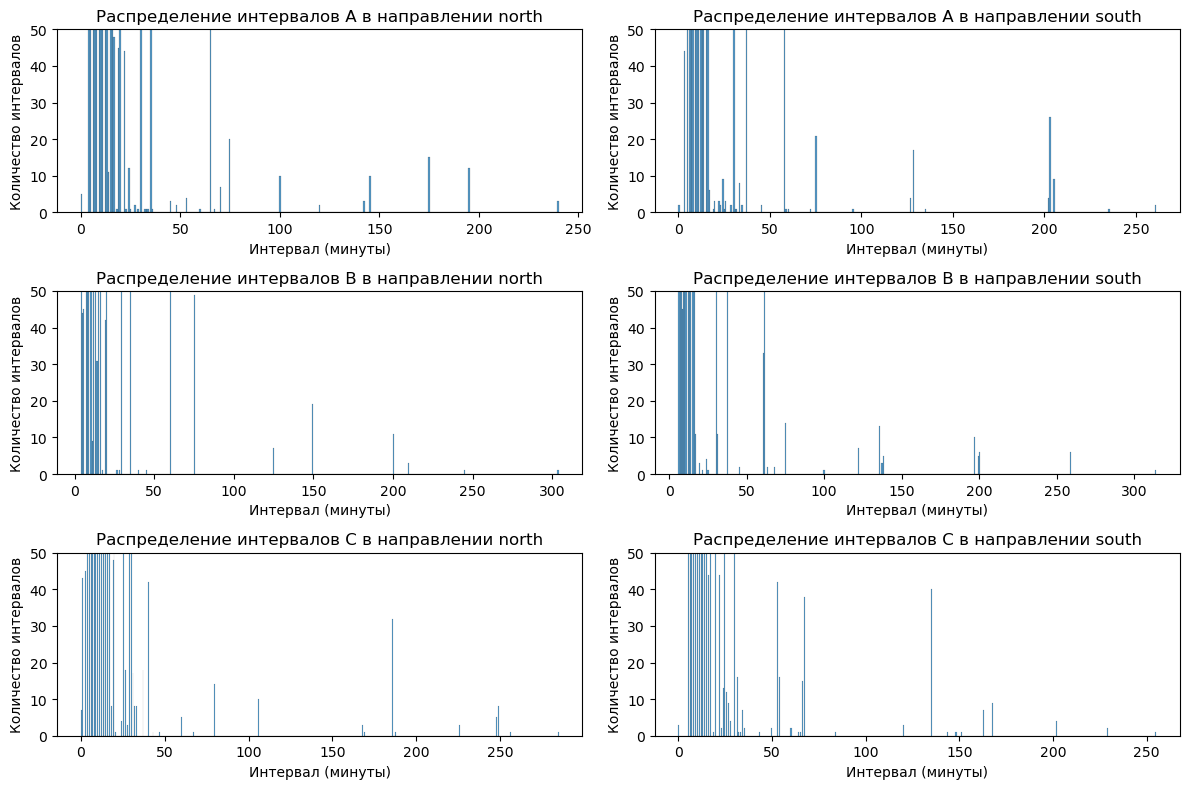

In [12]:
# Создаем гистограммы для разницы интервалов между автобусами (обрезаем сверху)
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for i, route in enumerate(df_new['route'].unique()):
    df_route = df_new[df_new['route'] == route]

    for j, direction in enumerate(df_new['direction'].unique()):
        df_subset = df_route[df_route['direction'] == direction]
        sns.histplot(data=df_subset, x='interval', ax=axes[i, j])
        plt.ylim(top=100)
        axes[i, j].set_title('Распределение интервалов {} в направлении {}'.format(route, direction))
        axes[i, j].set_ylim(top=50)
        axes[i, j].set_xlabel('Интервал (минуты)')
        axes[i, j].set_ylabel('Количество интервалов')
plt.tight_layout()
plt.show()

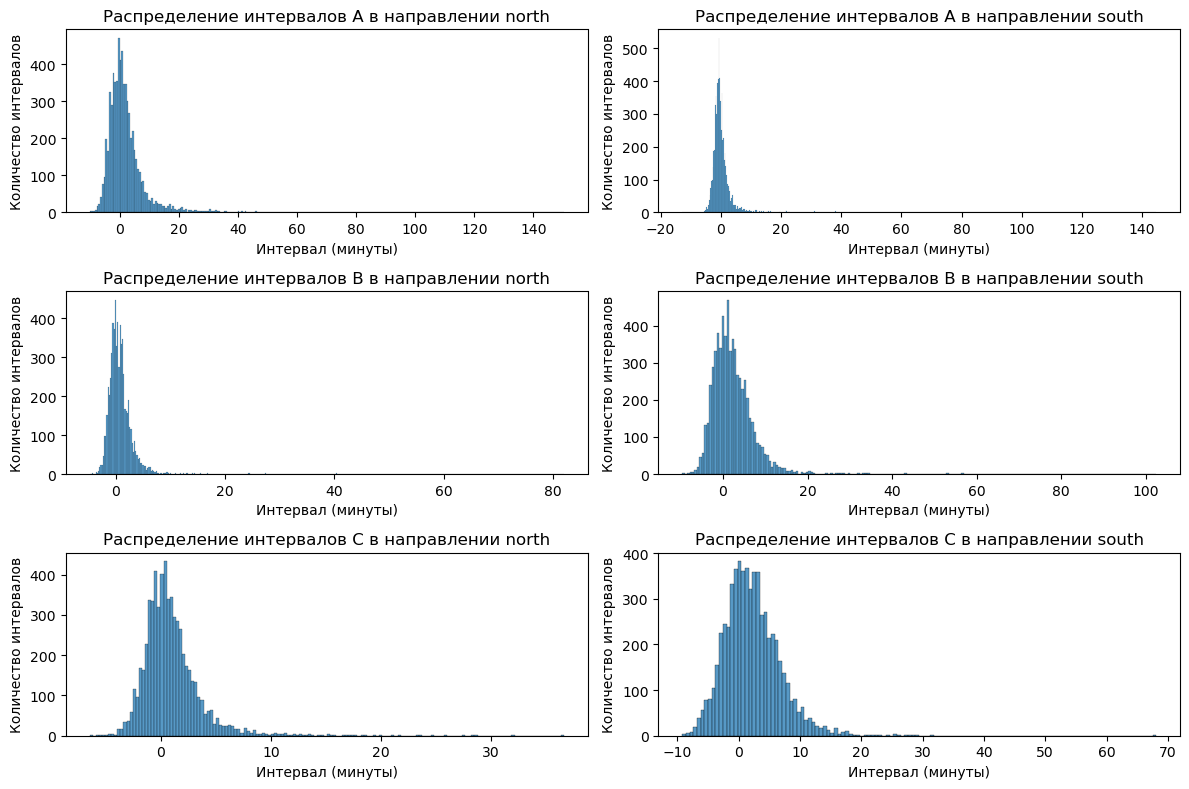

In [13]:
# Создаем гистограммы времени опоздания автобуса
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for i, route in enumerate(df_new['route'].unique()):
    df_route = df_new[df_new['route'] == route]
    
    for j, direction in enumerate(df_new['direction'].unique()):
        df_subset = df_route[df_route['direction'] == direction]
        sns.histplot(data=df_subset, x='delay', ax=axes[i, j])
        axes[i, j].set_title('Распределение интервалов {} в направлении {}'.format(route, direction))
        axes[i, j].set_xlabel('Интервал (минуты)')
        axes[i, j].set_ylabel('Количество интервалов')
plt.tight_layout()
plt.show()

In [14]:
median_interval = df_new.groupby(['route', 'direction'])['interval'].median()
print(median_interval)

route  direction
A      north        12.0
       south        12.0
B      north        12.0
       south        12.0
C      north        10.0
       south        12.0
Name: interval, dtype: float64


#### Можно, что либо сказать о маршрутах автобусов содержательно?

Распределение интервалов движения всех автобусов выглядит похожим образом и концентрируется около значения примерно 12 минут. Однако существуют и большие интервалы - это не выбросы, а движение в ночное время.

А вот время опоздания автобусов распределяется по логнормальному распределению (для автобуса С даже близкому к нормальному). Если мы получим медианные значения (лучше использовать для логнормального распределения), то заметим, что 3*median_interval практически полностью накрывает диапазон значений опоздания автобуса.

## Задание финальное ... для тех кто может
Давайте попробуем заполнить пропущенные данные в расписании  - `df_null`. Как это сделать правильно?

In [15]:
df_null['arrival'] = df_null[['data', 'actual']].astype(str).agg(' '.join, axis=1)
df_null.arrival = pd.to_datetime(df_null.arrival)
df_null = df_null.sort_values(['route', 'direction', 'arrival']).reset_index(drop=True)
median_delay = (df_new.groupby(['route', 'direction'])['delay'].median() * 60).reset_index()
df_nul = df_null.merge(median_delay, on=['route', 'direction'])
df_nul['scheduled'] = df_nul['arrival'] + pd.to_timedelta(df_nul['delay'], unit='s')
df_nul.head(3)

,data,route,direction,scheduled,actual,arrival,delay
0,2016-03-28,A,north,2016-03-28 16:49:05,16:48:21,2016-03-28 16:48:21,44.0
1,2016-04-01,A,north,2016-04-01 08:40:15,08:39:31,2016-04-01 08:39:31,44.0
2,2016-04-01,A,north,2016-04-01 17:43:06,17:42:22,2016-04-01 17:42:22,44.0
